# XGBoost Models

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing imputed data

USA_train_imputed = pd.read_csv("USA_train_imputed copy.csv")
USA_test_imputed = pd.read_csv("USA_test_imputed copy.csv")
USA_train_imputed.set_index('date', inplace=True)
USA_test_imputed.set_index('date', inplace=True)

Brazil_train_imputed = pd.read_csv("Brazil_train_imputed copy.csv")
Brazil_test_imputed = pd.read_csv("Brazil_test_imputed copy.csv")
Brazil_train_imputed.set_index('date', inplace=True)
Brazil_test_imputed.set_index('date', inplace=True)

Germany_train_imputed = pd.read_csv("Germany_train_imputed copy.csv")
Germany_test_imputed = pd.read_csv("Germany_test_imputed copy.csv")
Germany_train_imputed.set_index('date', inplace=True)
Germany_test_imputed.set_index('date', inplace=True)

Nigeria_train_imputed = pd.read_csv("Nigeria_train_imputed copy.csv")
Nigeria_test_imputed = pd.read_csv("Nigeria_test_imputed copy.csv")
Nigeria_train_imputed.set_index('date', inplace=True)
Nigeria_test_imputed.set_index('date', inplace=True)

China_train_imputed = pd.read_csv("China_train_imputed copy.csv")
China_test_imputed = pd.read_csv("China_test_imputed copy.csv")
China_train_imputed.set_index('date', inplace=True)
China_test_imputed.set_index('date', inplace=True)

Australia_train_imputed = pd.read_csv("Australia_train_imputed copy.csv")
Australia_test_imputed = pd.read_csv("Australia_test_imputed copy.csv")
Australia_train_imputed.set_index('date', inplace=True)
Australia_test_imputed.set_index('date', inplace=True)

## Dropping columns
After building the Prophet models, we determined that there were a number of variables in each country's data that had unique/constant values or were collinear with the target variable of 'new_cases'. We will drop these samme variables as well for developing the XGBoost model. You will see this later in the code, this is just an early note.

# USA model

In [3]:
# Drop columns based on work from developing Prophet Multivariate model. 
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
USA_train_imputed = USA_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 
                                                      'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                      'life_expectancy', 'human_development_index', 'location', 'continent', 'population', 
                                                      'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                      'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
USA_train_imputed['new_cases_Lag_7'] = USA_train_imputed['new_cases_Lag_7'].fillna(0)
USA_train_imputed['new_cases_Lag_14'] = USA_train_imputed['new_cases_Lag_14'].fillna(0)
USA_train_imputed["Weekend"] = USA_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
USA_test_imputed = USA_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 
                                                      'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                      'life_expectancy', 'human_development_index', 'location', 'continent', 'population', 
                                                      'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                      'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
USA_test_imputed['new_cases_Lag_7'][0:7] = USA_train_imputed['new_cases'][-7:]
USA_test_imputed['new_cases_Lag_14'][0:14] = USA_train_imputed['new_cases'][-14:]
USA_test_imputed["Weekend"] = USA_test_imputed["Weekend"].astype(int)

In [4]:
# Filling missing values of the lag features
def process(df, lag_values):
    ret = df[['new_cases']]
    for lag in lag_values:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0) 
USA_train_imputed_lagged = process(USA_train_imputed, lag_values=[1,7,14,30])
USA_test_imputed_lagged = process(USA_test_imputed, lag_values=[1,7,14,30])

In [5]:
# For training data
X_train = USA_train_imputed_lagged.drop(columns=['new_cases'])
y_train = USA_train_imputed_lagged['new_cases']

# For testing data
X_test = USA_test_imputed_lagged.drop(columns=['new_cases'])
y_test = USA_test_imputed_lagged['new_cases']

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter distributions
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 500]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [7]:
# Getting train predictions and train RMSE
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(train_pred, y_train))
train_rmse

2443.7105448273264

Text(0.5, 0.05, '\nRMSE: 2443.71')

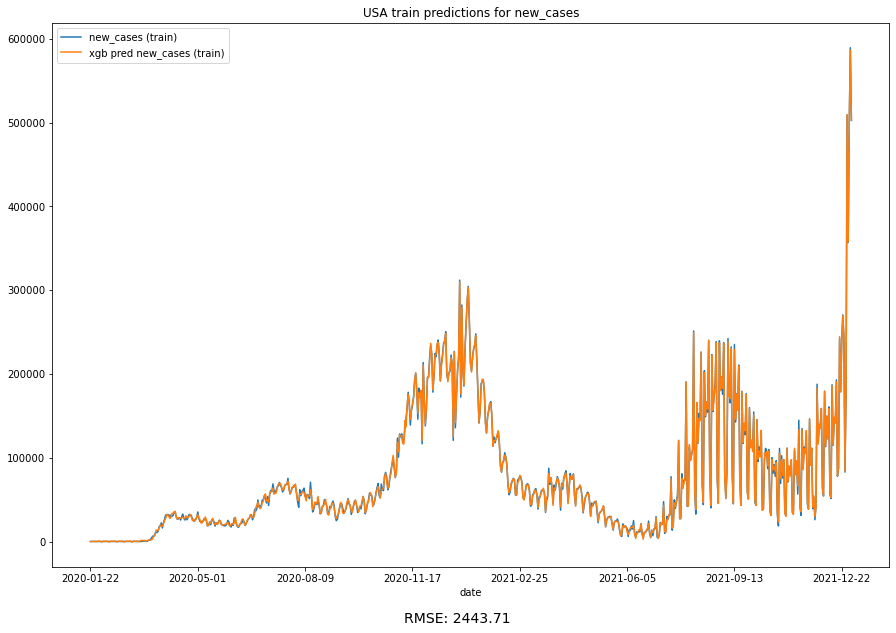

In [8]:
USA_train_imputed_lagged['xgb_predictions'] = train_pred
USA_train_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="USA train predictions for new_cases")
plt.legend(['new_cases (train)', 'xgb pred new_cases (train)'])
txt = f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [9]:
# Getting train predictions and train RMSE
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
test_rmse

338545.3955726402

Text(0.5, 0.05, '\nRMSE: 338545.40')

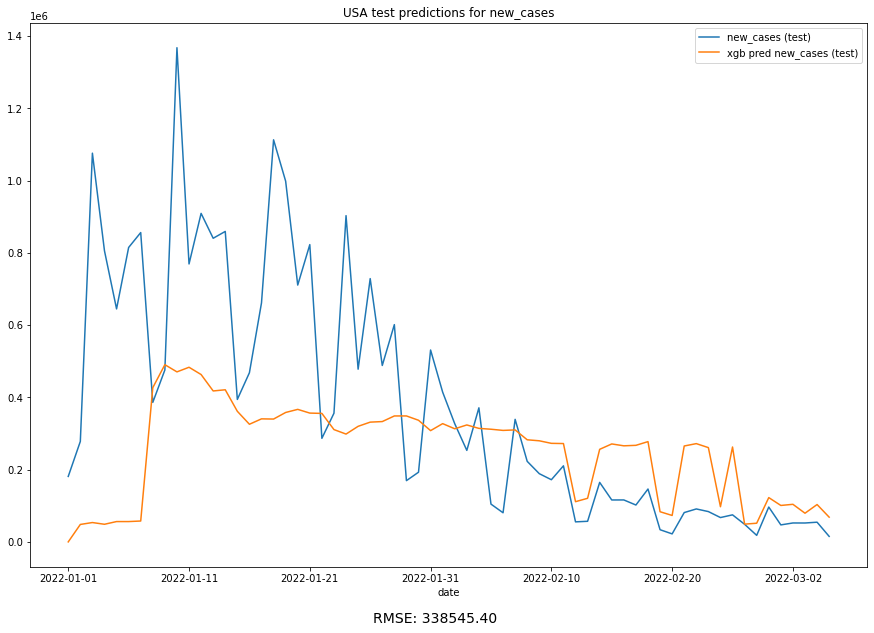

In [10]:
USA_test_imputed_lagged['xgb_predictions'] = test_pred
USA_test_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="USA test predictions for new_cases")
plt.legend(['new_cases (test)', 'xgb pred new_cases (test)'])
txt = f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

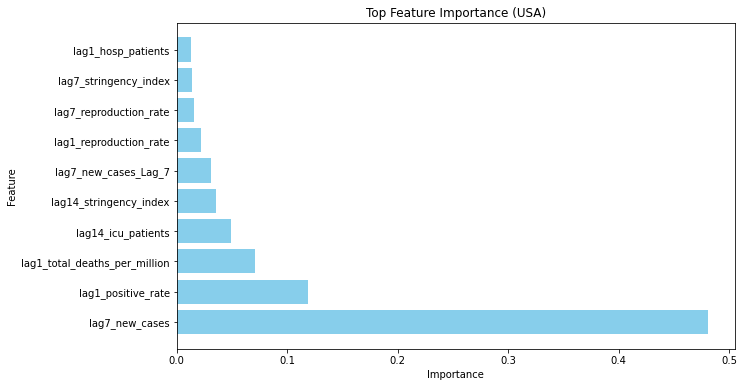

In [11]:
# Get feature importances
importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_n = 10 
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importance (USA)')
plt.show()

In [12]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                           Feature  Importance
38                  lag7_new_cases    0.481078
13              lag1_positive_rate    0.118506
2    lag1_total_deaths_per_million    0.070832
91              lag14_icu_patients    0.049305
74          lag14_stringency_index    0.035741
..                             ...         ...
83    lag14_new_tests_per_thousand    0.000000
82               lag14_total_tests    0.000000
80  lag14_total_tests_per_thousand    0.000000
79    lag14_new_deaths_per_million    0.000000
98         lag14_people_vaccinated    0.000000

[148 rows x 2 columns]


# Brazil Model

In [13]:
# Drop columns based on work from developing Prophet Multivariate model. 
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Brazil_train_imputed = Brazil_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                            'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                            'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                            'life_expectancy', 'human_development_index', 'population', 'location',
                                                            'continent', 'population', 
                                                            'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Brazil_train_imputed['new_cases_Lag_7'] = Brazil_train_imputed['new_cases_Lag_7'].fillna(0)
Brazil_train_imputed['new_cases_Lag_14'] = Brazil_train_imputed['new_cases_Lag_14'].fillna(0)
Brazil_train_imputed["Weekend"] = Brazil_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Brazil_test_imputed = Brazil_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                            'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                            'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                            'life_expectancy', 'human_development_index', 'population', 'location',
                                                            'continent', 'population', 
                                                            'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])


# Ensuring that the lag column values in test dataset are those of last values in train
Brazil_test_imputed['new_cases_Lag_7'][0:7] = Brazil_train_imputed['new_cases'][-7:]
Brazil_test_imputed['new_cases_Lag_14'][0:14] = Brazil_train_imputed['new_cases'][-14:]
Brazil_test_imputed["Weekend"] = Brazil_test_imputed["Weekend"].astype(int)

In [14]:
# Filling missing values of the lag features
Brazil_train_imputed_lagged = process(Brazil_train_imputed, lag_values=[1,7,14,30])
Brazil_test_imputed_lagged = process(Brazil_test_imputed, lag_values=[1,7,14,30])

In [15]:
# For training data
X_train = Brazil_train_imputed_lagged.drop(columns=['new_cases'])
y_train = Brazil_train_imputed_lagged['new_cases']

# For testing data
X_test = Brazil_test_imputed_lagged.drop(columns=['new_cases'])
y_test = Brazil_test_imputed_lagged['new_cases']

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter distributions
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 500]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
# Getting train predictions and train RMSE
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(train_pred, y_train))
train_rmse

1074.1460882024155

Text(0.5, 0.05, '\nRMSE: 1074.15')

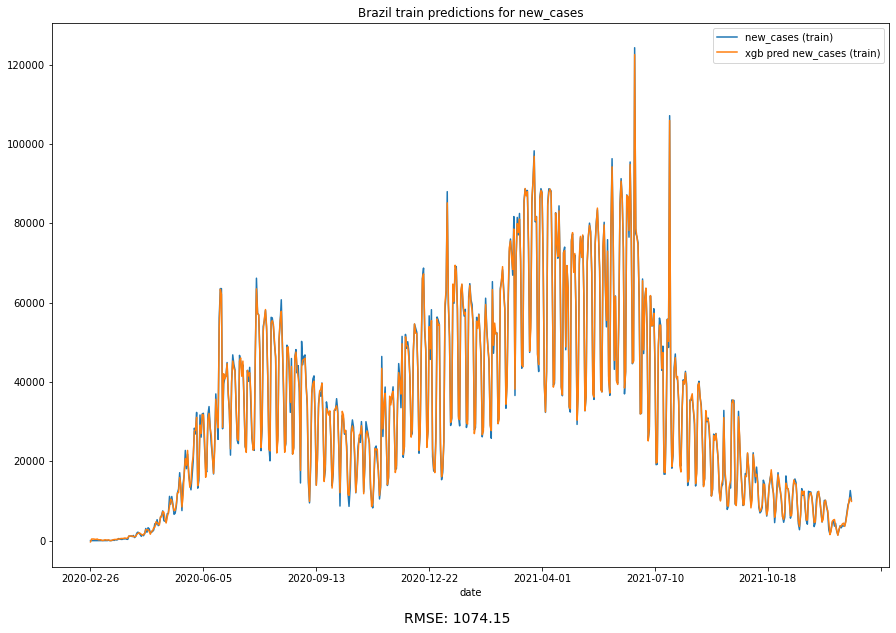

In [18]:
Brazil_train_imputed_lagged['xgb_predictions'] = train_pred
Brazil_train_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Brazil train predictions for new_cases")
plt.legend(['new_cases (train)', 'xgb pred new_cases (train)'])
txt = f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [19]:
# Getting train predictions and train RMSE
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
test_rmse

79247.83373298794

Text(0.5, 0.05, '\nRMSE: 79247.83')

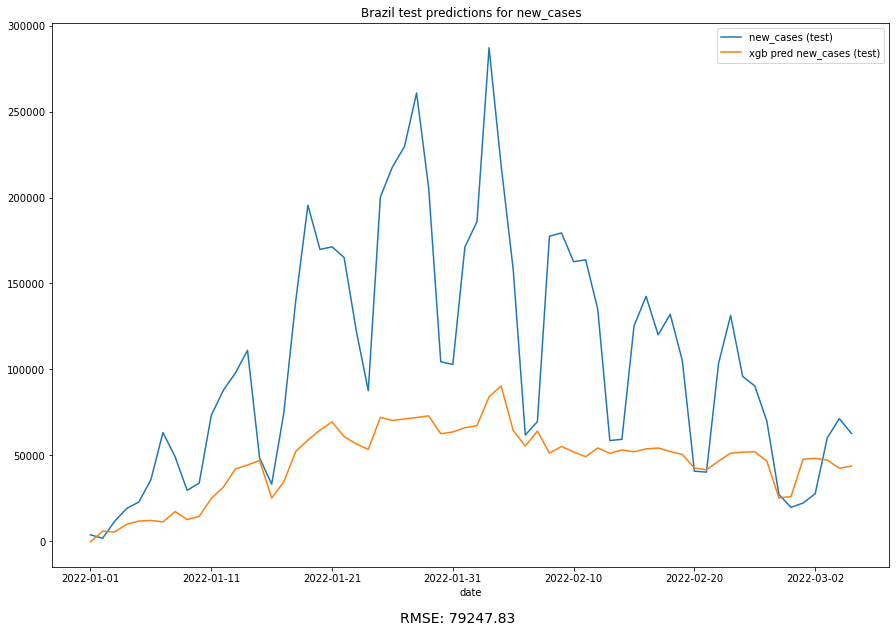

In [20]:
Brazil_test_imputed_lagged['xgb_predictions'] = test_pred
Brazil_test_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Brazil test predictions for new_cases")
plt.legend(['new_cases (test)', 'xgb pred new_cases (test)'])
txt = f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

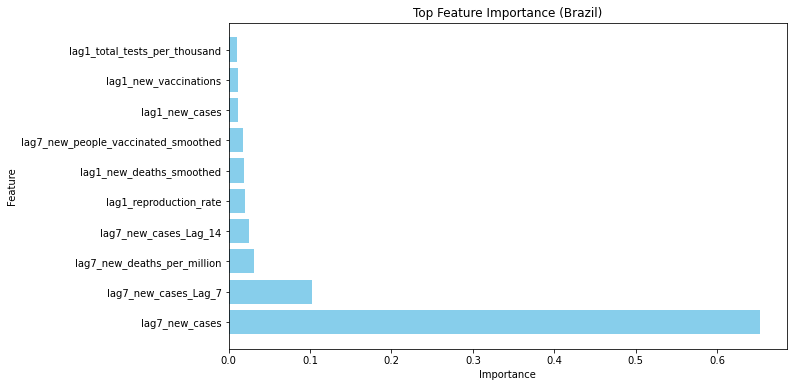

In [21]:
# Get feature importances
importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_n = 10 
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importance (Brazil)')
plt.show()

In [22]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                                Feature  Importance
26                       lag7_new_cases    0.652539
47                 lag7_new_cases_Lag_7    0.102186
28          lag7_new_deaths_per_million    0.031151
48                lag7_new_cases_Lag_14    0.025500
2                lag1_reproduction_rate    0.019951
..                                  ...         ...
30                      lag7_new_deaths    0.000000
70              lag14_people_vaccinated    0.000000
71  lag14_people_vaccinated_per_hundred    0.000000
72                lag14_new_cases_Lag_7    0.000000
74                        lag14_Weekend    0.000000

[100 rows x 2 columns]


# Germany Model

In [23]:
# Drop columns based on work from developing Prophet Multivariate model. 
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Germany_train_imputed = Germany_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                              'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
                                                              'hospital_beds_per_thousand', 'population', 'life_expectancy',
                                                              'continent', 'location', 'human_development_index',
                                                              'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                              'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Germany_train_imputed['new_cases_Lag_7'] = Germany_train_imputed['new_cases_Lag_7'].fillna(0)
Germany_train_imputed['new_cases_Lag_14'] = Germany_train_imputed['new_cases_Lag_14'].fillna(0)
Germany_train_imputed["Weekend"] = Germany_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Germany_test_imputed = Germany_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                              'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
                                                              'hospital_beds_per_thousand', 'population', 'life_expectancy',
                                                              'continent', 'location', 'human_development_index',
                                                              'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                              'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])


# Ensuring that the lag column values in test dataset are those of last values in train
Germany_test_imputed['new_cases_Lag_7'][0:7] = Germany_train_imputed['new_cases'][-7:]
Germany_test_imputed['new_cases_Lag_14'][0:14] = Germany_train_imputed['new_cases'][-14:]
Germany_test_imputed["Weekend"] = Germany_test_imputed["Weekend"].astype(int)

In [24]:
# Filling missing values of the lag features
def process(df, lag_values):
    ret = df[['new_cases']]
    for lag in lag_values:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0) 
Germany_train_imputed_lagged = process(Germany_train_imputed, lag_values=[1,7,14,30])
Germany_test_imputed_lagged = process(Germany_test_imputed, lag_values=[1,7,14,30])

# For training data
X_train = Germany_train_imputed_lagged.drop(columns=['new_cases'])
y_train = Germany_train_imputed_lagged['new_cases']

# For testing data
X_test = Germany_test_imputed_lagged.drop(columns=['new_cases'])
y_test = Germany_test_imputed_lagged['new_cases']

#----------------------
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter distributions
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 500]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [25]:
# Getting train predictions and train RMSE
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(train_pred, y_train))
train_rmse

2331.080561650276

Text(0.5, 0.05, '\nRMSE: 2331.08')

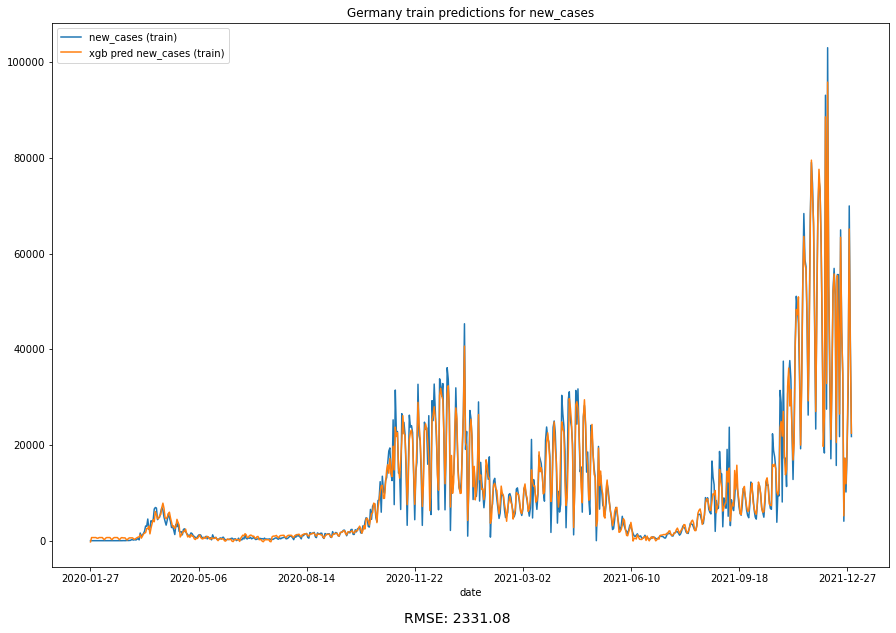

In [26]:
Germany_train_imputed_lagged['xgb_predictions'] = train_pred
Germany_train_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Germany train predictions for new_cases")
plt.legend(['new_cases (train)', 'xgb pred new_cases (train)'])
txt = f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [27]:
# Getting train predictions and train RMSE
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
test_rmse

122658.65574661804

Text(0.5, 0.05, '\nRMSE: 122658.66')

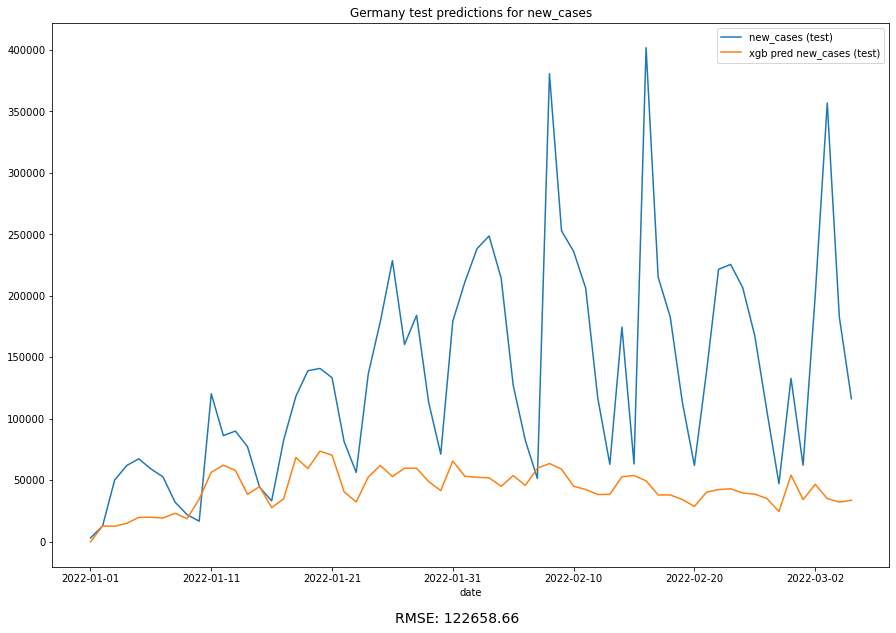

In [28]:
Germany_test_imputed_lagged['xgb_predictions'] = test_pred
Germany_test_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Germany test predictions for new_cases")
plt.legend(['new_cases (test)', 'xgb pred new_cases (test)'])
txt = f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

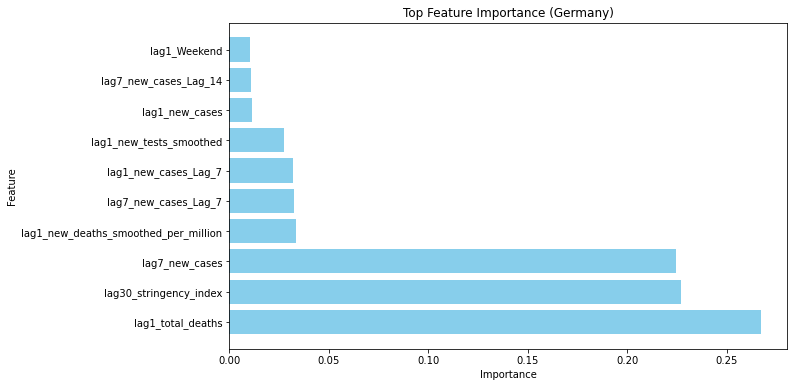

In [29]:
# Get feature importances
importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_n = 10 
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importance (Germany)')
plt.show()

In [30]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                                  Feature  Importance
5                       lag1_total_deaths    0.267106
93                 lag30_stringency_index    0.227152
32                         lag7_new_cases    0.224612
13   lag1_new_deaths_smoothed_per_million    0.033282
59                   lag7_new_cases_Lag_7    0.032261
..                                    ...         ...
50     lag7_people_vaccinated_per_hundred    0.000000
49    lag7_total_vaccinations_per_hundred    0.000000
48           lag7_people_fully_vaccinated    0.000000
47                 lag7_people_vaccinated    0.000000
123                         lag30_Weekend    0.000000

[124 rows x 2 columns]


# China Model

In [31]:
# Drop columns based on work from developing Prophet Multivariate model. 
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
China_train_imputed = China_train_imputed.drop(columns = ['iso_code', 'population', 'population_density', 'median_age',
                                                          'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                          'cardiovasc_death_rate', 'life_expectancy', 'human_development_index',
                                                          'hospital_beds_per_thousand', 'continent', 'location',
                                                          'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                          'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
China_train_imputed['new_cases_Lag_7'] = China_train_imputed['new_cases_Lag_7'].fillna(0)
China_train_imputed['new_cases_Lag_14'] = China_train_imputed['new_cases_Lag_14'].fillna(0)
China_train_imputed["Weekend"] = China_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
China_test_imputed = China_test_imputed.drop(columns = ['iso_code', 'population', 'population_density', 'median_age',
                                                          'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                          'cardiovasc_death_rate', 'life_expectancy', 'human_development_index',
                                                          'hospital_beds_per_thousand', 'continent', 'location',
                                                          'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                          'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
China_test_imputed['new_cases_Lag_7'][0:7] = China_train_imputed['new_cases'][-7:]
China_test_imputed['new_cases_Lag_14'][0:14] = China_train_imputed['new_cases'][-14:]
China_test_imputed["Weekend"] = China_test_imputed["Weekend"].astype(int)

In [32]:
# Filling missing values of the lag features
def process(df, lag_values):
    ret = df[['new_cases']]
    for lag in lag_values:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0) 
China_train_imputed_lagged = process(China_train_imputed, lag_values=[1,7,14,30])
China_test_imputed_lagged = process(China_test_imputed, lag_values=[1,7,14,30])

In [33]:
# For training data
X_train = China_train_imputed_lagged.drop(columns=['new_cases'])
y_train = China_train_imputed_lagged['new_cases']

# For testing data
X_test = China_test_imputed_lagged.drop(columns=['new_cases'])
y_test = China_test_imputed_lagged['new_cases']

In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter distributions
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 500]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [35]:
# Getting train predictions and train RMSE
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(train_pred, y_train))
train_rmse

8.156661746556466

Text(0.5, 0.05, '\nRMSE: 8.16')

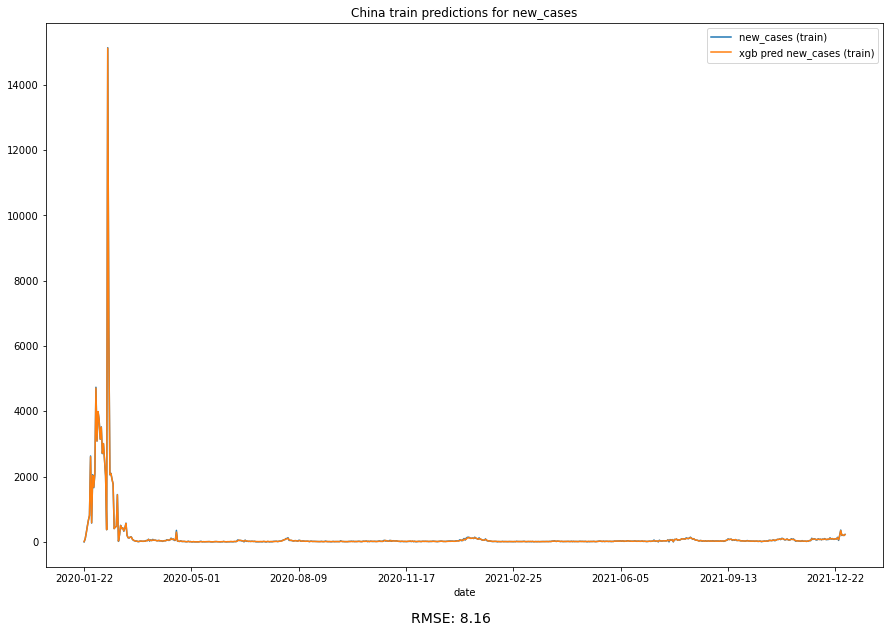

In [36]:
China_train_imputed_lagged['xgb_predictions'] = train_pred
China_train_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="China train predictions for new_cases")
plt.legend(['new_cases (train)', 'xgb pred new_cases (train)'])
txt = f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [37]:
# Getting train predictions and train RMSE
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
test_rmse

157.2778102804628

Text(0.5, 0.05, '\nRMSE: 157.28')

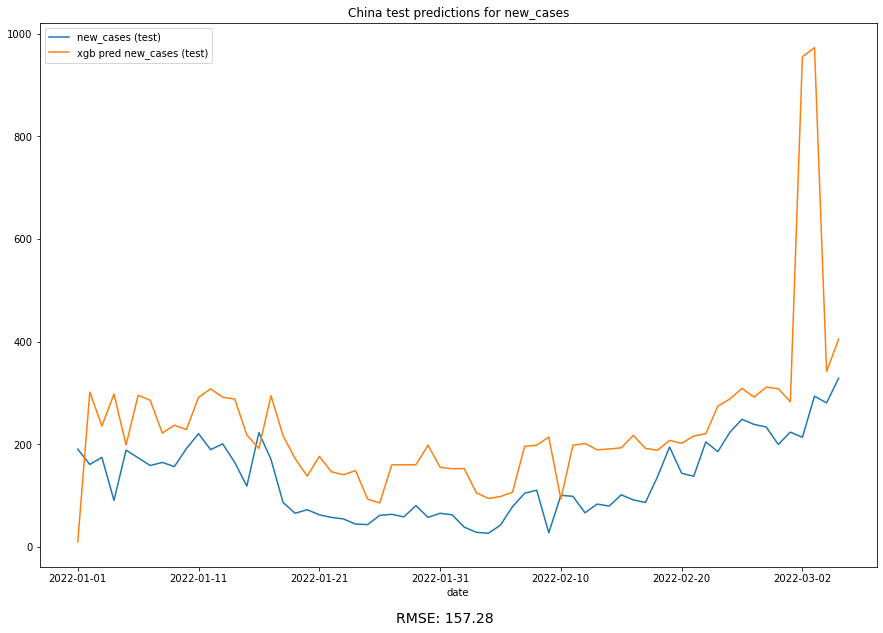

In [38]:
China_test_imputed_lagged['xgb_predictions'] = test_pred
China_test_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="China test predictions for new_cases")
plt.legend(['new_cases (test)', 'xgb pred new_cases (test)'])
txt = f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

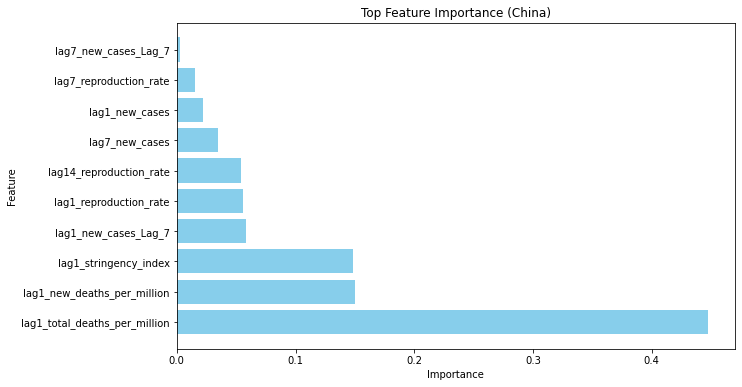

In [39]:
# Get feature importances
importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_n = 10 
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importance (China)')
plt.show()

In [40]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                                       Feature  Importance
1                lag1_total_deaths_per_million    0.447624
4                  lag1_new_deaths_per_million    0.150333
0                        lag1_stringency_index    0.148593
14                        lag1_new_cases_Lag_7    0.058526
3                       lag1_reproduction_rate    0.056153
..                                         ...         ...
16                                lag1_Weekend    0.000000
29         lag7_total_vaccinations_per_hundred    0.000000
28                     lag7_total_vaccinations    0.000000
27  lag7_new_vaccinations_smoothed_per_million    0.000000
46        lag14_total_vaccinations_per_hundred    0.000000

[68 rows x 2 columns]


# Nigeria Model

In [41]:
# Drop columns based on work from developing Prophet Multivariate model. 
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Nigeria_train_imputed = Nigeria_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                              'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
                                                              'handwashing_facilities', 'life_expectancy', 'human_development_index',
                                                              'population', 'location', 'continent',
                                                              'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                              'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Nigeria_train_imputed['new_cases_Lag_7'] = Nigeria_train_imputed['new_cases_Lag_7'].fillna(0)
Nigeria_train_imputed['new_cases_Lag_14'] = Nigeria_train_imputed['new_cases_Lag_14'].fillna(0)
Nigeria_train_imputed["Weekend"] = Nigeria_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Nigeria_test_imputed = Nigeria_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                            'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate',
                                                            'handwashing_facilities', 'life_expectancy', 'human_development_index',
                                                            'population', 'location', 'continent',
                                                            'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                            'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Ensuring that the lag column values in test dataset are those of last values in train
Nigeria_test_imputed['new_cases_Lag_7'][0:7] = Nigeria_train_imputed['new_cases'][-7:]
Nigeria_test_imputed['new_cases_Lag_14'][0:14] = Nigeria_train_imputed['new_cases'][-14:]
Nigeria_test_imputed["Weekend"] = Nigeria_test_imputed["Weekend"].astype(int)

In [42]:
# Filling missing values of the lag features
def process(df, lag_values):
    ret = df[['new_cases']]
    for lag in lag_values:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0) 
Nigeria_train_imputed_lagged = process(Nigeria_train_imputed, lag_values=[1,7,14,30])
Nigeria_test_imputed_lagged = process(Nigeria_test_imputed, lag_values=[1,7,14,30])

In [43]:
# For training data
X_train = Nigeria_train_imputed_lagged.drop(columns=['new_cases'])
y_train = Nigeria_train_imputed_lagged['new_cases']

# For testing data
X_test = Nigeria_test_imputed_lagged.drop(columns=['new_cases'])
y_test = Nigeria_test_imputed_lagged['new_cases']

In [44]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter distributions
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 500]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
# Getting train predictions and train RMSE
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(train_pred, y_train))
train_rmse

50.08932761882562

Text(0.5, 0.05, '\nRMSE: 50.09')

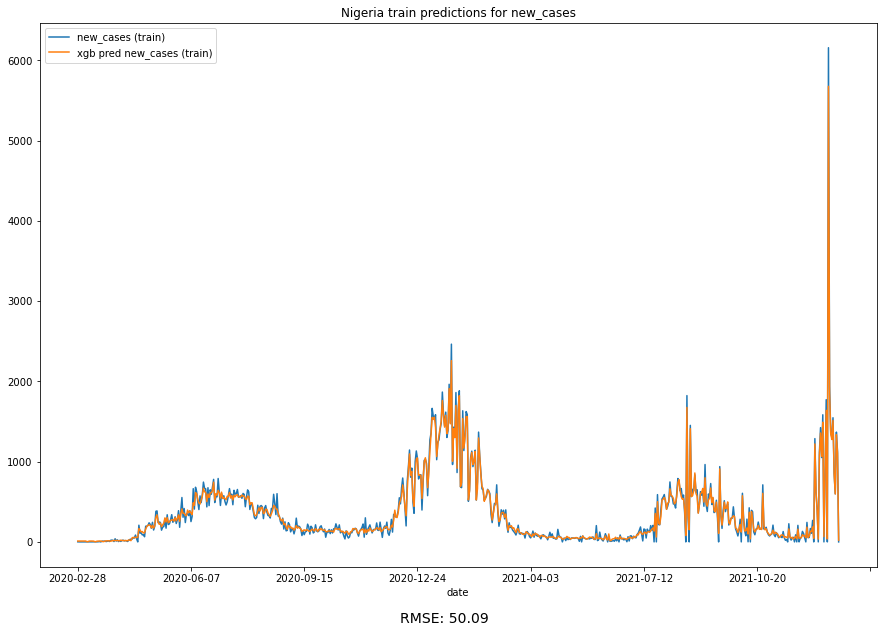

In [46]:
Nigeria_train_imputed_lagged['xgb_predictions'] = train_pred
Nigeria_train_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Nigeria train predictions for new_cases")
plt.legend(['new_cases (train)', 'xgb pred new_cases (train)'])
txt = f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [47]:
# Getting train predictions and train RMSE
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
test_rmse

1374.0198933236754

Text(0.5, 0.05, '\nRMSE: 1374.02')

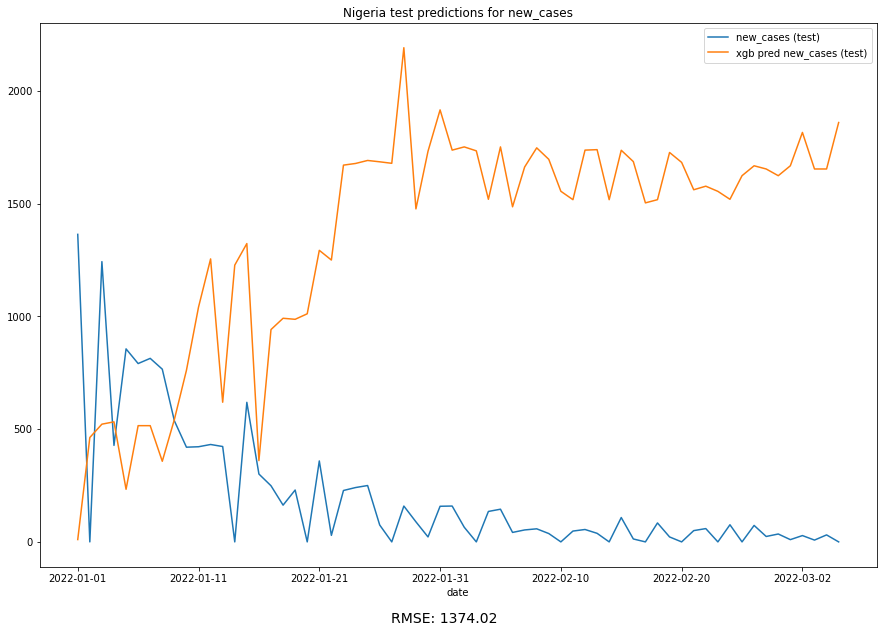

In [48]:
Nigeria_test_imputed_lagged['xgb_predictions'] = test_pred
Nigeria_test_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Nigeria test predictions for new_cases")
plt.legend(['new_cases (test)', 'xgb pred new_cases (test)'])
txt = f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

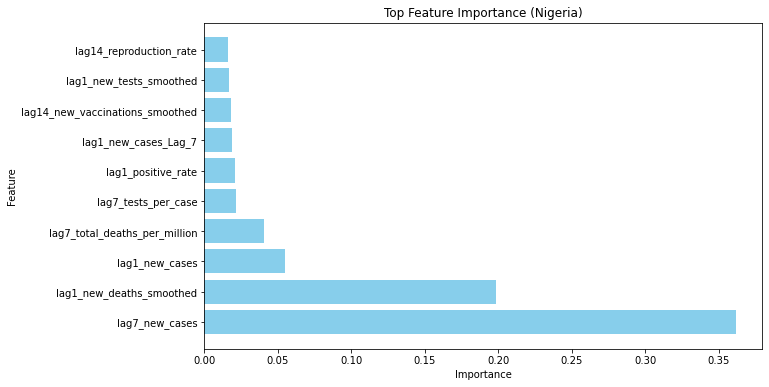

In [49]:
# Get feature importances
importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_n = 10 
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importance (Nigeria)')
plt.show()

In [50]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                                       Feature  Importance
21                              lag7_new_cases    0.361423
7                     lag1_new_deaths_smoothed    0.198690
1                               lag1_new_cases    0.054761
22               lag7_total_deaths_per_million    0.040588
29                         lag7_tests_per_case    0.021662
..                                         ...         ...
48       lag14_new_deaths_smoothed_per_million    0.000000
36  lag7_new_vaccinations_smoothed_per_million    0.000000
45                lag14_new_deaths_per_million    0.000000
43                          lag14_total_deaths    0.000000
40                      lag14_stringency_index    0.000000

[80 rows x 2 columns]


# Australia Model

In [51]:
# Drop columns based on work from developing Prophet Multivariate model. 
# Drop columns with constant values (low variance) and collinearity with 'new_cases'
Australia_train_imputed = Australia_train_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                                  'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                                  'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                                  'life_expectancy', 'human_development_index', 'location', 'continent',
                                                                  'population', 'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                                  'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])

# Fix Lag Columns so values at beginning are 0 instead of missing
Australia_train_imputed['new_cases_Lag_7'] = Australia_train_imputed['new_cases_Lag_7'].fillna(0)
Australia_train_imputed['new_cases_Lag_14'] = Australia_train_imputed['new_cases_Lag_14'].fillna(0)
Australia_train_imputed["Weekend"] = Australia_train_imputed["Weekend"].astype(int)

# Dropping the same columns for test dataset based on conclusions of train dataset
Australia_test_imputed = Australia_test_imputed.drop(columns = ['iso_code', 'population_density', 'median_age', 'aged_65_older',
                                                                'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                                                                'cardiovasc_death_rate', 'hospital_beds_per_thousand',
                                                                'life_expectancy', 'human_development_index', 'location', 'continent',
                                                                'population', 'total_cases_per_million', 'total_cases', 'new_cases_per_million',
                                                                'new_cases_smoothed_per_million', 'new_cases_smoothed', 'Rolling_Mean_new_cases'])


# Ensuring that the lag column values in test dataset are those of last values in train
Australia_test_imputed['new_cases_Lag_7'][0:7] = Australia_train_imputed['new_cases'][-7:]
Australia_test_imputed['new_cases_Lag_14'][0:14] = Australia_train_imputed['new_cases'][-14:]
Australia_test_imputed["Weekend"] = Australia_test_imputed["Weekend"].astype(int)

In [52]:
# Filling missing values of the lag features
def process(df, lag_values):
    ret = df[['new_cases']]
    for lag in lag_values:
        lagdf = df.shift(lag)
        lagdf.columns=[f'lag{lag}_' + str(col) for col in lagdf.columns]
        ret=pd.concat([ret, lagdf], axis=1)
    return ret.fillna(0) 
Australia_train_imputed_lagged = process(Australia_train_imputed, lag_values=[1,7,14,30])
Australia_test_imputed_lagged = process(Australia_test_imputed, lag_values=[1,7,14,30])

In [53]:
# For training data
X_train = Australia_train_imputed_lagged.drop(columns=['new_cases'])
y_train = Australia_train_imputed_lagged['new_cases']

# For testing data
X_test = Australia_test_imputed_lagged.drop(columns=['new_cases'])
y_test = Australia_test_imputed_lagged['new_cases']

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter distributions
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 200, 300, 500]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Train the final model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [55]:
# Getting train predictions and train RMSE
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(train_pred, y_train))
train_rmse

38.424813765278714

Text(0.5, 0.05, '\nRMSE: 38.42')

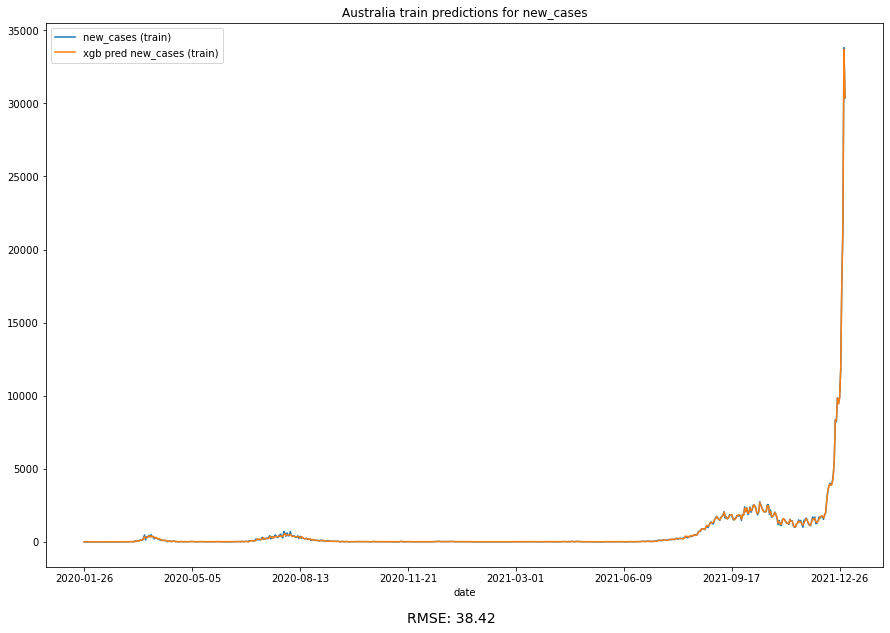

In [56]:
Australia_train_imputed_lagged['xgb_predictions'] = train_pred
Australia_train_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Australia train predictions for new_cases")
plt.legend(['new_cases (train)', 'xgb pred new_cases (train)'])
txt = f"\nRMSE: {train_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

In [57]:
# Getting train predictions and train RMSE
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
test_rmse

36408.2804777916

Text(0.5, 0.05, '\nRMSE: 36408.28')

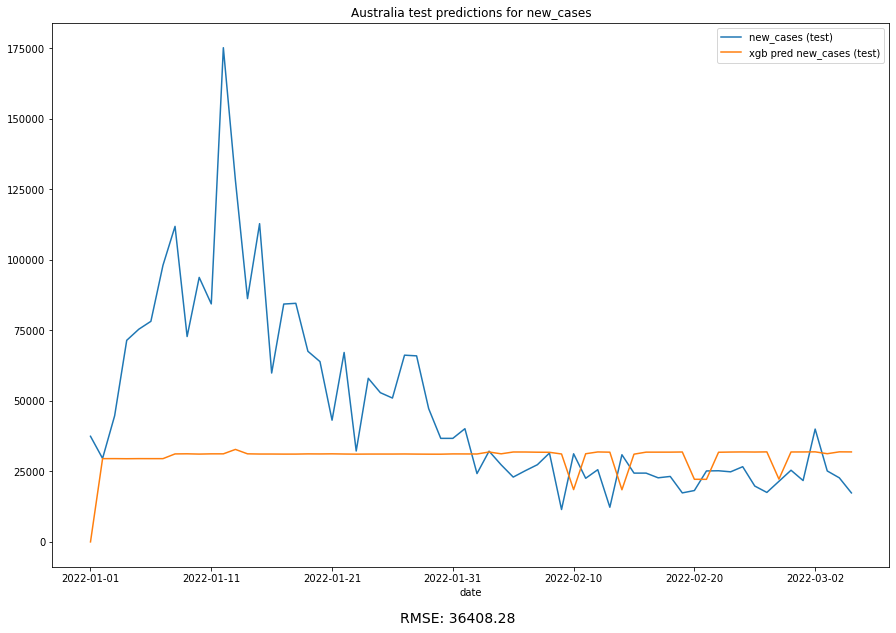

In [58]:
Australia_test_imputed_lagged['xgb_predictions'] = test_pred
Australia_test_imputed_lagged.plot(y=["new_cases", "xgb_predictions"], figsize=(15,10), 
                              title="Australia test predictions for new_cases")
plt.legend(['new_cases (test)', 'xgb pred new_cases (test)'])
txt = f"\nRMSE: {test_rmse:.2f}"
plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=14)

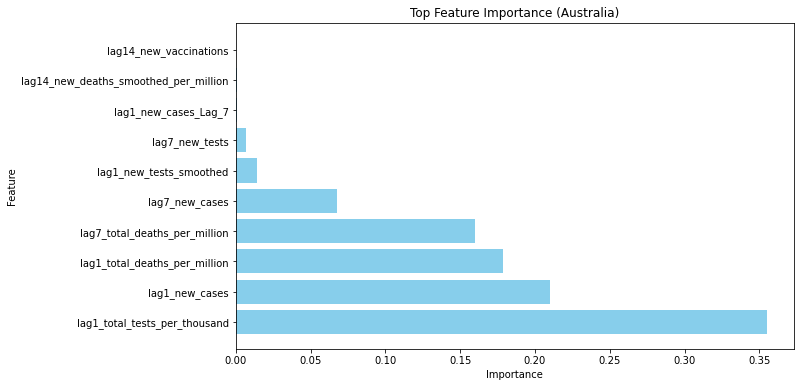

In [59]:
# Get feature importances
importances = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
top_n = 10 
top_features = feature_importance_df.head(top_n)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importance (Australia)')
plt.show()

In [60]:
# Get feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted DataFrame
print(feature_importance_df)

                                             Feature  Importance
6                      lag1_total_tests_per_thousand    0.355149
1                                     lag1_new_cases    0.210264
2                      lag1_total_deaths_per_million    0.178347
37                     lag7_total_deaths_per_million    0.159637
36                                    lag7_new_cases    0.067697
..                                               ...         ...
60                           lag7_total_vaccinations    0.000000
59   lag7_new_people_vaccinated_smoothed_per_hundred    0.000000
57        lag7_new_vaccinations_smoothed_per_million    0.000000
55                                 lag7_icu_patients    0.000000
139                                    lag30_Weekend    0.000000

[140 rows x 2 columns]
